<a href="https://colab.research.google.com/github/JJooKim/detecting_defective_product/blob/main/defective_product_classification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Projects/defective_product_classification

/content/drive/MyDrive/Projects/defective_product_classification


## DataSet 불러오고 확인

In [3]:
import numpy as np
import pandas as pd
data_path = './'
train = pd.read_csv(data_path + 'train.csv', encoding='utf-8')

In [4]:
train.shape

(10000, 12)

In [5]:
train.info()
# wtcd NULL value 있돠

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   index    10000 non-null  int64  
 1   Num      10000 non-null  object 
 2   prod     10000 non-null  object 
 3   insp     10000 non-null  object 
 4   date     10000 non-null  object 
 5   buydate  10000 non-null  object 
 6   ingr_A   10000 non-null  float64
 7   ingr_B   10000 non-null  float64
 8   ingr_C   10000 non-null  float64
 9   wtcd     9989 non-null   object 
 10  gram     10000 non-null  float64
 11  label    10000 non-null  int64  
dtypes: float64(4), int64(2), object(6)
memory usage: 937.6+ KB


## EDA를 위한 전처리

In [47]:
train.head()

,index,Num,prod,insp,date,buydate,ingr_A,ingr_B,ingr_C,wtcd,gram,label
0,2,20230618산천074246A,GBMD,C,2023-06-18,2023-09-18,399.4063,6.4035,6.9409,F3,970.32,1
1,9,20230518창하053396B,GGMD,L,2023-05-18,2023-07-08,130.0951,5.8245,6.2857,F1,2490.08,0
2,10,20230505창하063135B,KCMD,C,2023-05-05,2023-07-02,131.5192,5.8040,6.0607,F3,487.37,0
3,12,20230505산천001612A,GBMD,K,2023-05-05,2023-06-04,128.5978,6.8720,6.1705,F3,707.94,1
4,16,20230409수성016088C,JJBB,K,2023-04-09,2023-04-14,320.6915,5.7474,6.3695,F3,1978.66,0


### index, Column Drop
* 아무 의미 없는 unique value이므로 Drop

In [48]:
train = train.drop(columns = ['index'])

### Num Column 범주형 변수로 전처리
* 제품번호 문자열의 가운데 깨진 글자들은 범주형으로 봐도 될 것 같음.

In [49]:
train['Num2'] = train['Num'].str[-1]
train['Num'] = train['Num'].str[8:-7]

Num_mapping = {
  '산천': 'Sanchun',
  '창하': 'Changha',
  '수성': 'Susung',
  '오포': 'Opo',
}


train['Num'] = train['Num'].map(Num_mapping)





### `date`, `buydate` Column 구성 요소별로 Column 나누기
* 연, 월, 일로 나누기

In [50]:
train['date_year'] = train['date'].apply(lambda x: x.split('-')[0])
train['date_month'] = train['date'].apply(lambda x: x.split('-')[1])
train['date_day'] = train['date'].apply(lambda x: x.split('-')[2])

In [51]:
train['buydate_year'] = train['buydate'].apply(lambda x: x.split('-')[0])
train['buydate_month'] = train['buydate'].apply(lambda x: x.split('-')[1])
train['buydate_day'] = train['buydate'].apply(lambda x: x.split('-')[2])

### `date`, `buydate`에 대한 요일 Column 만들기
* 연, 월, 일로 나누기

In [52]:
from datetime import datetime
import calendar

train['date_weekday'] = train['date'].apply(
    lambda dateString:
    calendar.day_name[datetime.strptime(dateString, "%Y-%m-%d").weekday()])

In [53]:
train['buydate_weekday'] = train['buydate'].apply(
    lambda dateString:
    calendar.day_name[datetime.strptime(dateString, "%Y-%m-%d").weekday()])

### 검수일자 구입일자 간의 날짜 차이를 나타내는 `days_between` column 생성
* 의미 있을 듯?

In [54]:
train['days_between'] = (pd.to_datetime(train['buydate']) - pd.to_datetime(train['date'])).dt.days

In [55]:
train

,Num,prod,insp,date,buydate,ingr_A,ingr_B,ingr_C,wtcd,gram,...,Num2,date_year,date_month,date_day,buydate_year,buydate_month,buydate_day,date_weekday,buydate_weekday,days_between
0,Sanchun,GBMD,C,2023-06-18,2023-09-18,399.4063,6.4035,6.9409,F3,970.32,...,A,2023,06,18,2023,09,18,Sunday,Monday,92
1,Changha,GGMD,L,2023-05-18,2023-07-08,130.0951,5.8245,6.2857,F1,2490.08,...,B,2023,05,18,2023,07,08,Thursday,Saturday,51
2,Changha,KCMD,C,2023-05-05,2023-07-02,131.5192,5.8040,6.0607,F3,487.37,...,B,2023,05,05,2023,07,02,Friday,Sunday,58
3,Sanchun,GBMD,K,2023-05-05,2023-06-04,128.5978,6.8720,6.1705,F3,707.94,...,A,2023,05,05,2023,06,04,Friday,Sunday,30
4,Susung,JJBB,K,2023-04-09,2023-04-14,320.6915,5.7474,6.3695,F3,1978.66,...,C,2023,04,09,2023,04,14,Sunday,Friday,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Sanchun,KCMD,C,2023-06-20,2023-07-08,405.6626,6.2900,6.8467,F3,777.82,...,A,2023,06,20,2023,07,08,Tuesday,Saturday,18
9996,Opo,GGMD,K,2023-05-15,2023-05-25,129.1664,6.0345,6.5257,F3,2548.73,...,A,2023,05,15,2023,05,25,Monday,Thursday,10
9997,Changha,GGMD,L,2023-06-14,2023-09-10,403.9895,6.2698,6.7227,F1,2769.71,...,B,2023,06,14,2023,09,10,Wednesday,Sunday,88
9998,Sanchun,JJBB,K,2023-04-05,2023-04-16,309.4751,5.7987,6.5499,F3,2005.46,...,A,2023,04,05,2023,04,16,Wednesday,Sunday,11


## EDA

In [56]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

### Class 분포 확인

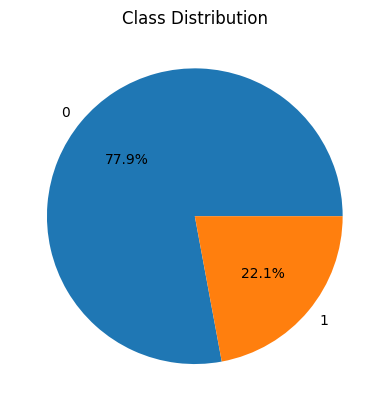

In [57]:
plt.pie(train["label"].value_counts(), labels=['0','1'], autopct='%1.1f%%')
plt.title('Class Distribution')
plt.show()

### Date 에 따른 label 분포

In [58]:
# 분포 비율을 표시하기위한 함수

def write_percent(ax):

  for idx, patch in enumerate(ax.patches):
    height = patch.get_height()
    width = patch.get_width()
    left_coord = patch.get_x()

    if idx < int(len(ax.patches) / 2):
      total_size = height + ax.patches[int(idx + len(ax.patches) / 2 )].get_height()
    else:
      total_size = height + ax.patches[int(idx - len(ax.patches) / 2 )].get_height()
    percent = height / total_size*100

    ax.text(x=left_coord + width/2.0,
            y=height + total_size*0.001,
            s=f'{percent:1.1f}%',
            ha='center', size=12)


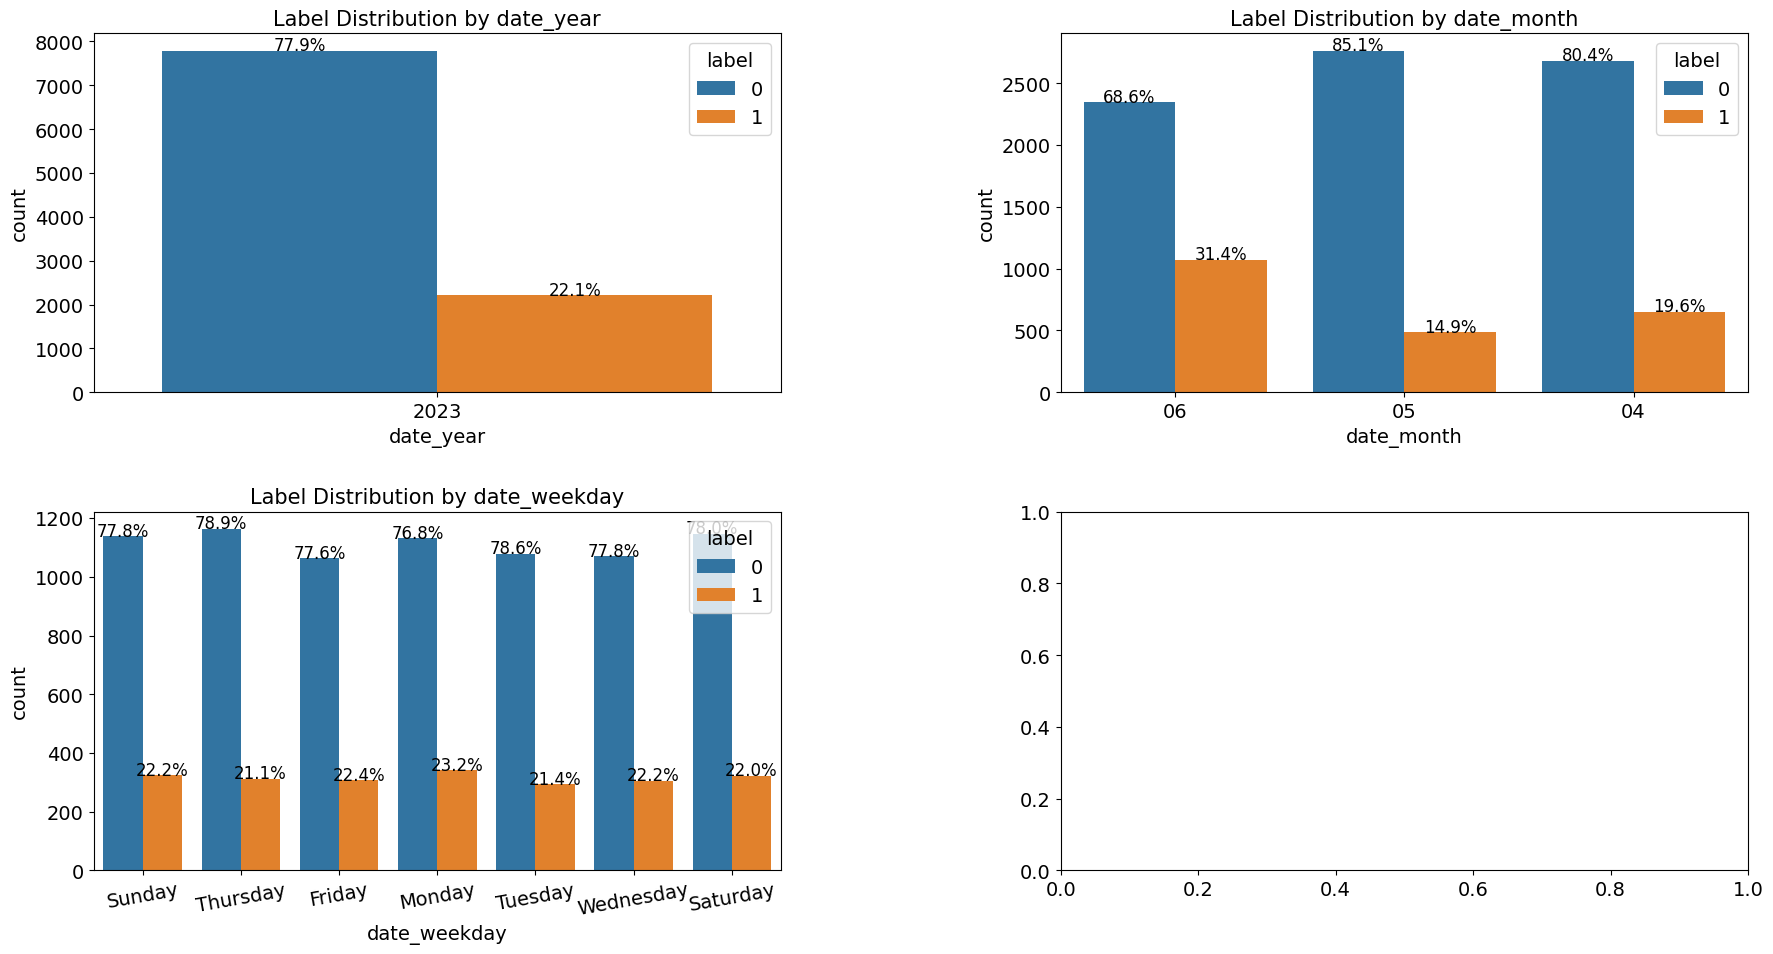

In [59]:
mpl.rc('font', size=14)
mpl.rc('axes', titlesize=15)
figure, axes = plt.subplots(nrows=2, ncols=2) # 2행 2열 Figure 생성
plt.tight_layout() # 그래프 사이에 여백 확보
figure.set_size_inches(20,10) # 전체 Figure 크기를 10 x 9인치로 설정

sns.countplot(x='date_year', data=train, hue='label', ax=axes[0,0])
sns.countplot(x='date_month', data=train, hue='label', ax=axes[0,1])
sns.countplot(x='date_weekday', data=train, hue='label', ax=axes[1,0])

axes[0, 0].set(title='Label Distribution by date_year')
axes[0, 1].set(title='Label Distribution by date_month')
axes[1, 0].set(title='Label Distribution by date_weekday')
axes[1, 0].tick_params(axis='x', labelrotation=10)

write_percent(axes[0,0])

write_percent(axes[0,1])

write_percent(axes[1,0])

### 월간 label 추이 based on Data Month

In [60]:
label_count = train.groupby(['date', 'label']).size().reset_index(name='count')
label_count_4 = label_count[label_count['date'].str[6]=='4']
label_count_5 = label_count[label_count['date'].str[6]=='5']
label_count_6 = label_count[label_count['date'].str[6]=='6']

[Text(0, 0, '01'),
 Text(1, 0, '02'),
 Text(2, 0, '03'),
 Text(3, 0, '04'),
 Text(4, 0, '05'),
 Text(5, 0, '06'),
 Text(6, 0, '07'),
 Text(7, 0, '08'),
 Text(8, 0, '09'),
 Text(9, 0, '10'),
 Text(10, 0, '11'),
 Text(11, 0, '12'),
 Text(12, 0, '13'),
 Text(13, 0, '14'),
 Text(14, 0, '15'),
 Text(15, 0, '16'),
 Text(16, 0, '17'),
 Text(17, 0, '18'),
 Text(18, 0, '19'),
 Text(19, 0, '20'),
 Text(20, 0, '21'),
 Text(21, 0, '22'),
 Text(22, 0, '23'),
 Text(23, 0, '24'),
 Text(24, 0, '25'),
 Text(25, 0, '26'),
 Text(26, 0, '27'),
 Text(27, 0, '28'),
 Text(28, 0, '29')]

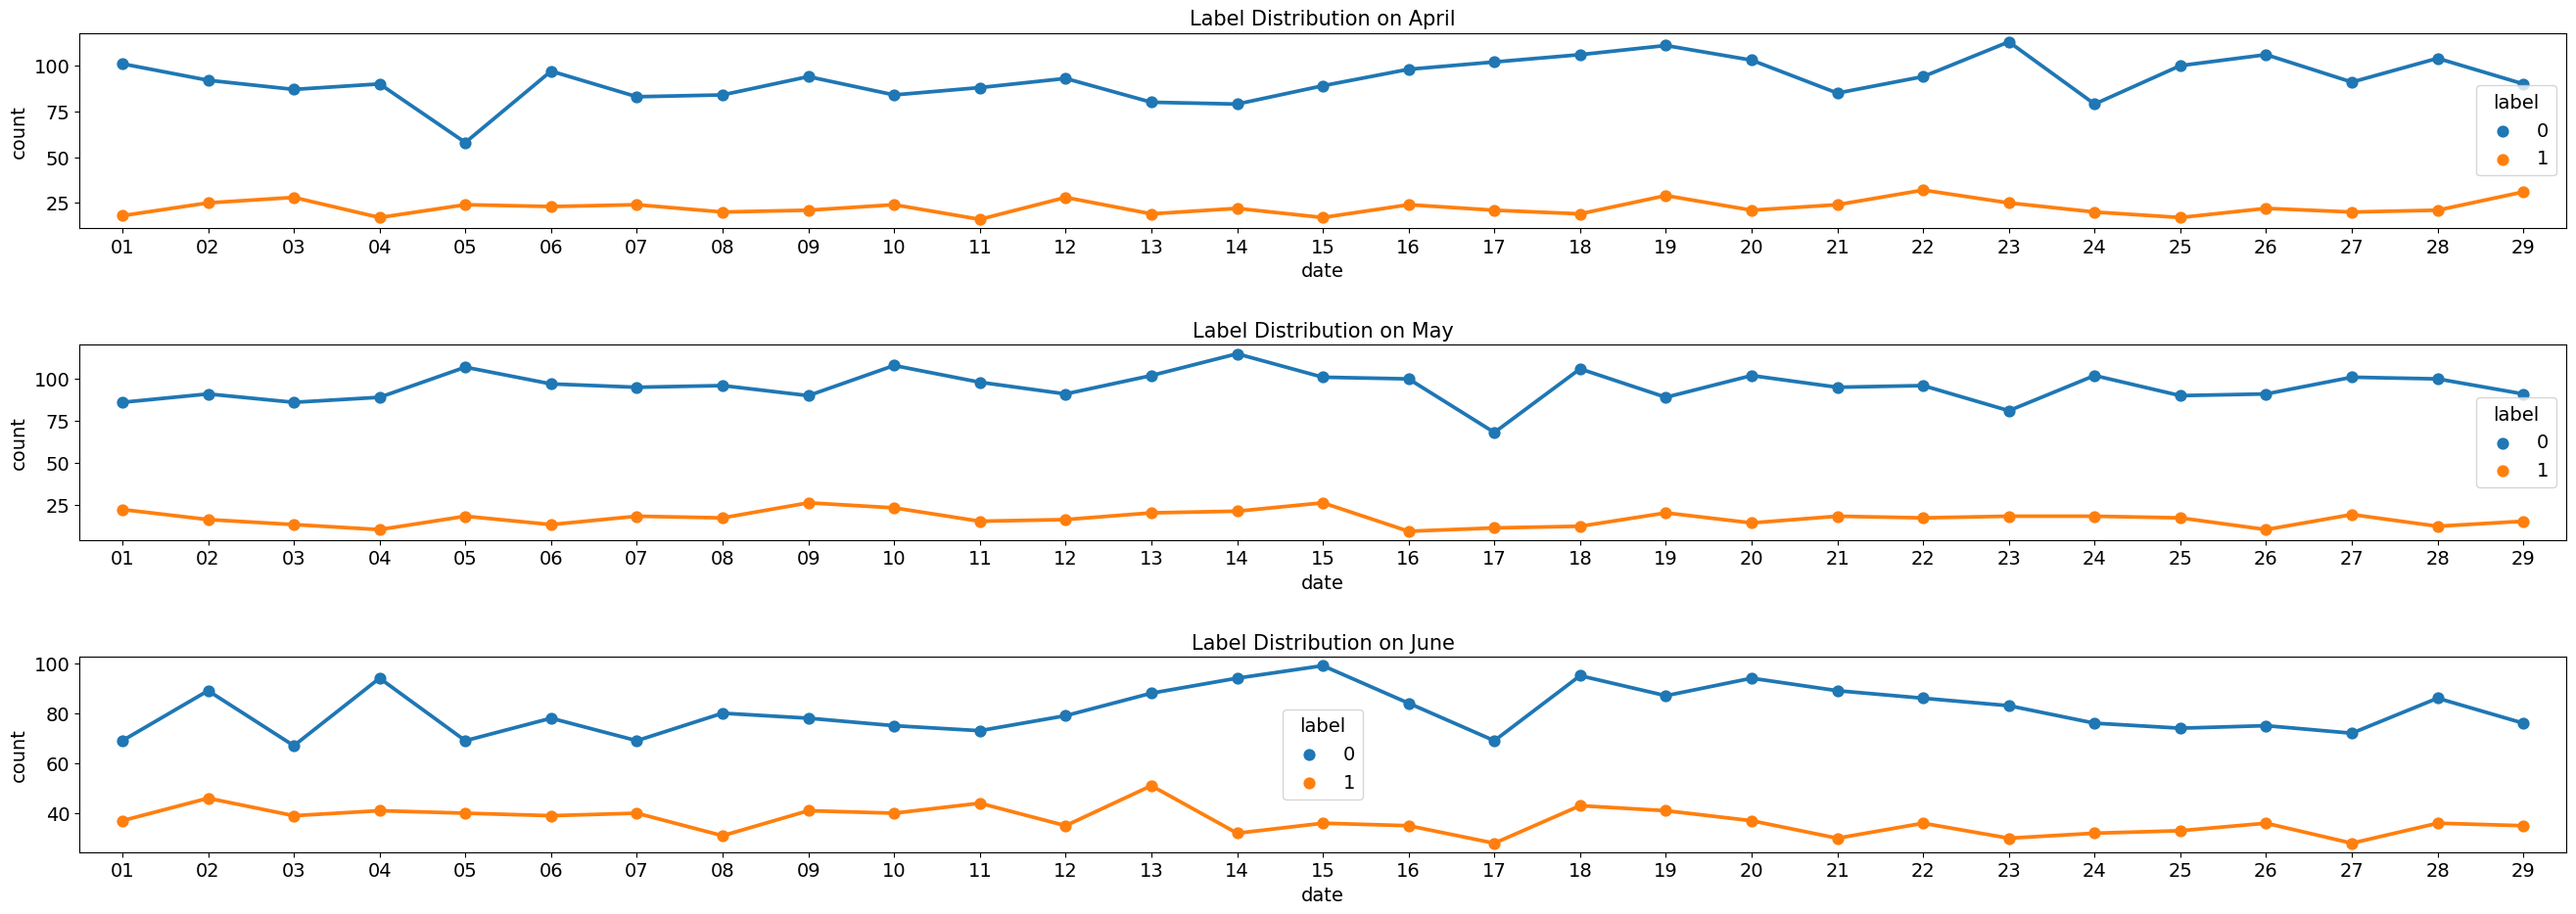

In [61]:
mpl.rc('font', size=14)
mpl.rc('axes', titlesize=15)
figure, axes = plt.subplots(nrows=3, ncols=1) # 2행 2열 Figure 생성
plt.tight_layout() # 그래프 사이에 여백 확보
figure.set_size_inches(30,10) # 전체 Figure 크기를 10 x 9인치로 설정

sns.pointplot(x='date', y='count', data=label_count_4, hue='label', ax=axes[0])
sns.pointplot(x='date', y='count', data=label_count_5, hue='label', ax=axes[1])
sns.pointplot(x='date', y='count', data=label_count_6, hue='label', ax=axes[2])


axes[0].set(title='Label Distribution on April')
axes[1].set(title='Label Distribution on May')
axes[2].set(title='Label Distribution on June')


axes[0].set_xticklabels(label_count_4['date'].str[-2:].unique())
axes[1].set_xticklabels(label_count_5['date'].str[-2:].unique())
axes[2].set_xticklabels(label_count_6['date'].str[-2:].unique())


### BuyDate에 따른 label 분포

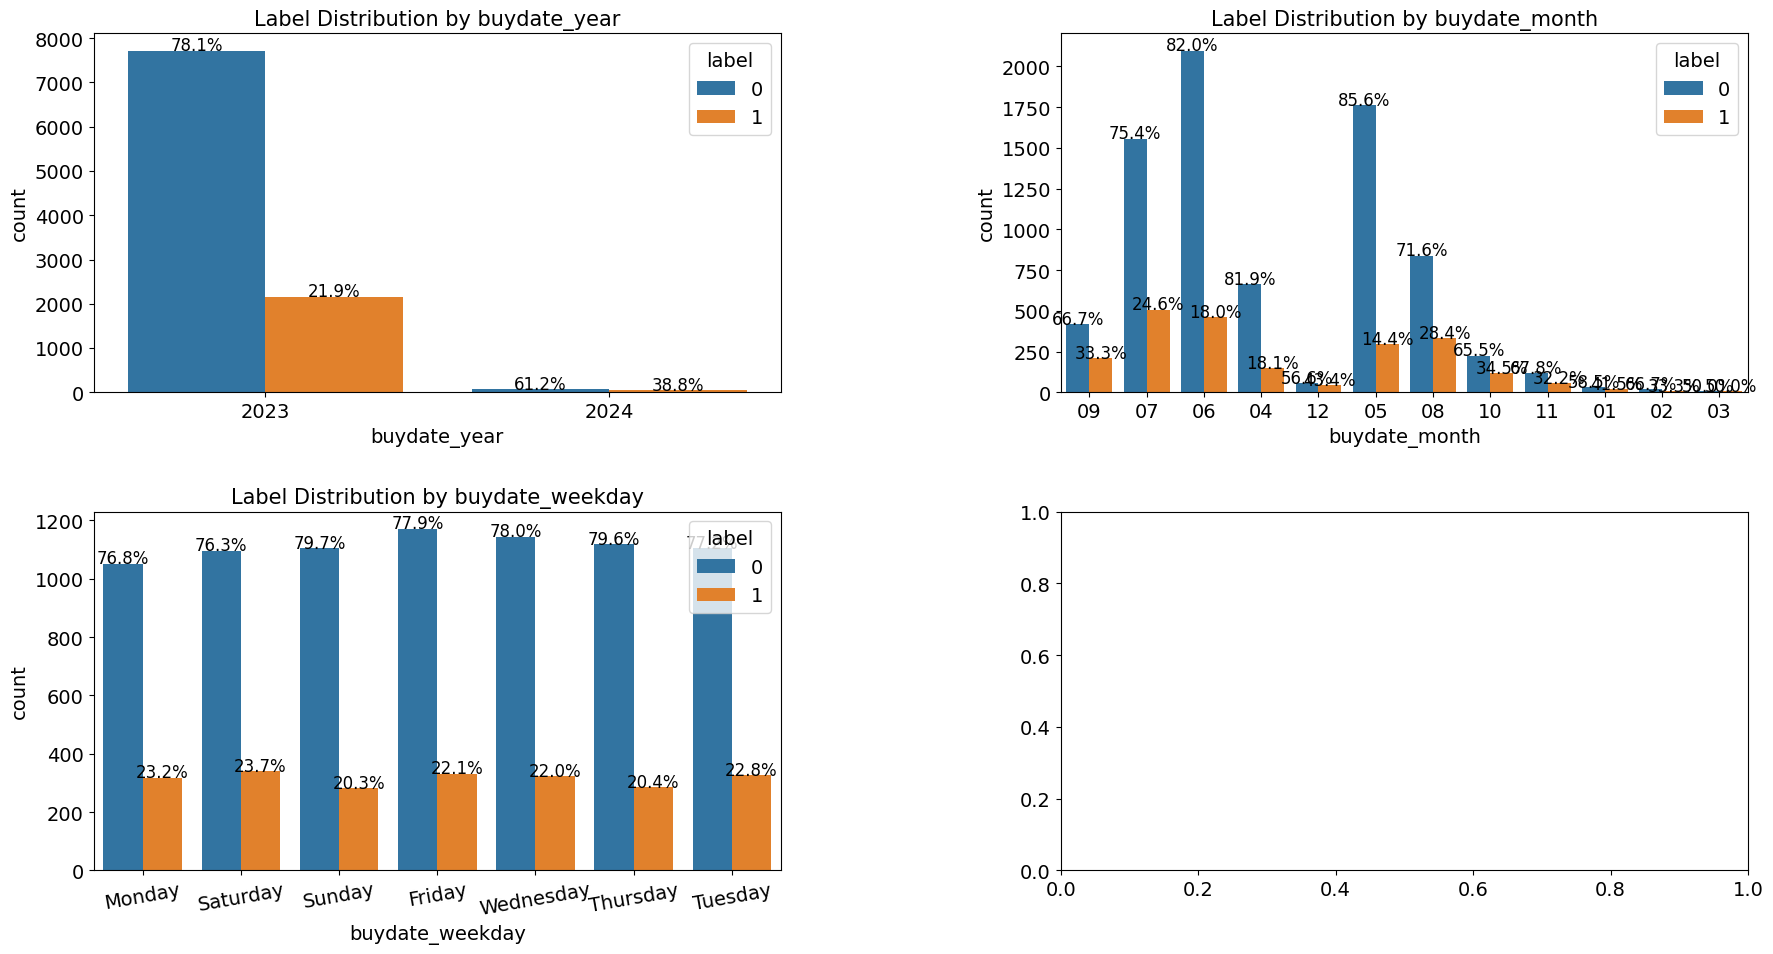

In [62]:
mpl.rc('font', size=14)
mpl.rc('axes', titlesize=15)
figure, axes = plt.subplots(nrows=2, ncols=2) # 2행 2열 Figure 생성
plt.tight_layout() # 그래프 사이에 여백 확보
figure.set_size_inches(20,10) # 전체 Figure 크기를 10 x 9인치로 설정

sns.countplot(x='buydate_year', data=train, hue='label', ax=axes[0,0])
sns.countplot(x='buydate_month', data=train, hue='label', ax=axes[0,1])
sns.countplot(x='buydate_weekday', data=train, hue='label', ax=axes[1,0])

axes[0, 0].set(title='Label Distribution by buydate_year')
axes[0, 1].set(title='Label Distribution by buydate_month')
axes[1, 0].set(title='Label Distribution by buydate_weekday')
axes[1, 0].tick_params(axis='x', labelrotation=10)

write_percent(axes[0,0])

write_percent(axes[0,1])

write_percent(axes[1,0])

### Num. prod, insp. wtcd 에 따른 label 분포

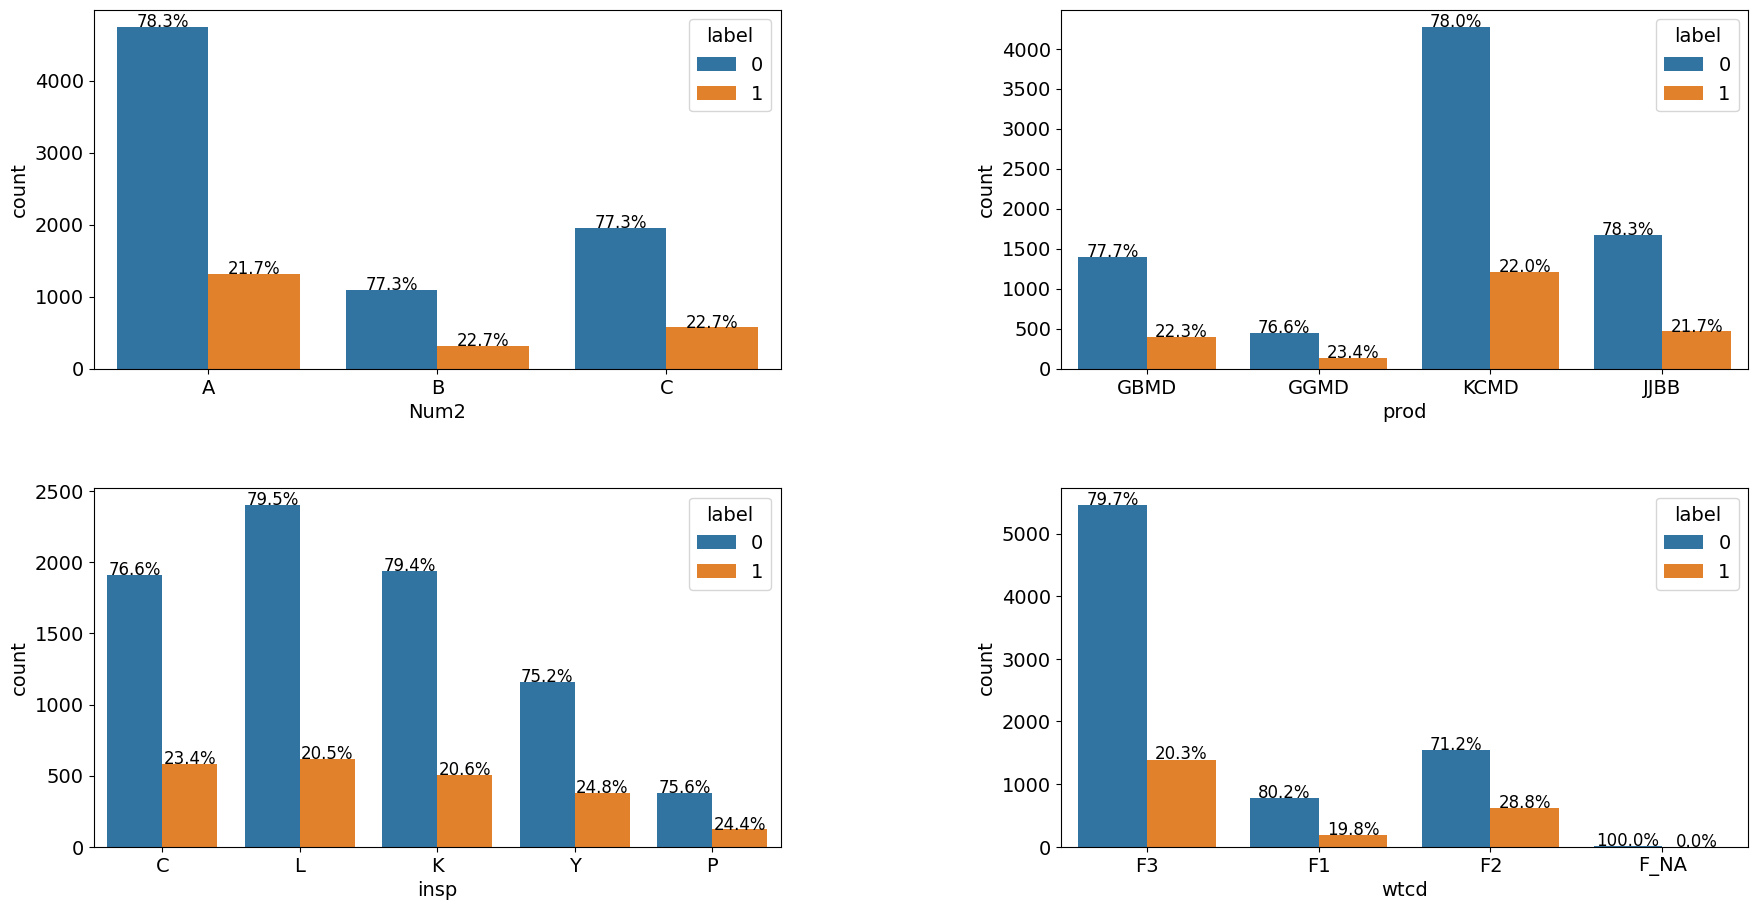

In [63]:
mpl.rc('font', size=14)
mpl.rc('axes', titlesize=15)
figure, axes = plt.subplots(nrows=2, ncols=2) # 2행 2열 Figure 생성
plt.tight_layout() # 그래프 사이에 여백 확보
figure.set_size_inches(20,10) # 전체 Figure 크기를 10 x 9인치로 설정

sns.countplot(x='Num2', data=train, hue='label', ax=axes[0,0])
sns.countplot(x='prod', data=train, hue='label', ax=axes[0,1])
sns.countplot(x='insp', data=train, hue='label', ax=axes[1,0])

train_fill_Na = train.copy()
train_fill_Na['wtcd'] = train['wtcd'].fillna('F_NA')
sns.countplot(x='wtcd', data=train_fill_Na, hue='label', ax=axes[1,1])

write_percent(axes[0,0])

write_percent(axes[0,1])

write_percent(axes[1,0])


write_percent(axes[1,1])

#### Checking Null Value in column `wtcd`

In [ ]:
train[train['wtcd'].isnull()]

,Num,prod,insp,date,buydate,ingr_A,ingr_B,ingr_C,wtcd,gram,...,Num2,date_year,date_month,date_day,buydate_year,buydate_month,buydate_day,date_weekday,buydate_weekday,days_between
152,Opo,KCMD,K,2023-05-08,2023-05-12,128.3390,6.8925,6.2336,NaN,491.08,...,A,2023,05,08,2023,05,12,Monday,Friday,4
1500,Opo,JJBB,K,2023-04-20,2023-06-17,319.0863,64811.0000,6.7270,NaN,1972.70,...,A,2023,04,20,2023,06,17,Thursday,Saturday,58
1867,Sanchun,KCMD,C,2023-06-05,2023-06-20,401.9915,6.3852,6.9117,NaN,786.90,...,A,2023,06,05,2023,06,20,Monday,Tuesday,15
2965,Opo,JJBB,C,2023-05-20,2023-06-17,131.5546,7.4636,6.1067,NaN,1782.97,...,A,2023,05,20,2023,06,17,Saturday,Saturday,28
3159,Opo,KCMD,C,2023-06-10,2023-07-12,400.2173,6.0006,6.9271,NaN,769.65,...,A,2023,06,10,2023,07,12,Saturday,Wednesday,32
3503,Opo,KCMD,K,2023-06-13,2023-06-26,396.8673,6.2746,6.9455,NaN,769.83,...,A,2023,06,13,2023,06,26,Tuesday,Monday,13
4750,Opo,GBMD,L,2023-04-14,2023-10-12,321.9846,74528.0000,6.1506,NaN,897.94,...,A,2023,04,14,2023,10,12,Friday,Thursday,181
6213,Changha,KCMD,K,2023-04-23,2023-07-07,318.4377,6.3588,6.4903,NaN,677.45,...,B,2023,04,23,2023,07,07,Sunday,Friday,75
8404,Sanchun,KCMD,C,2023-04-27,2023-09-30,321.5667,6.6244,5.8504,NaN,700.87,...,A,2023,04,27,2023,09,30,Thursday,Saturday,156
8801,Changha,JJBB,K,2023-04-13,2023-04-26,315.0384,5.8219,6.3853,NaN,1967.82,...,A,2023,04,13,2023,04,26,Thursday,Wednesday,13


### ingr_A, ingr_B, ingr_C, gram의 label에 따른 분포

In [81]:
import pandas as pd
import numpy as np



# Check the initial label distribution
print("Initial label distribution:")
print(train['label'].value_counts())

# Balance the labels
label_0_indices = train[train['label'] == 0].index
random_indices = np.random.choice(label_0_indices, size=2208, replace=False)

balanced_df = pd.concat([train[train['label'] == 1], train.loc[random_indices]])

# Check the balanced label distribution
print("\nBalanced label distribution:")
print(balanced_df['label'].value_counts())


Initial label distribution:
0    7792
1    2208
Name: label, dtype: int64

Balanced label distribution:
1    2208
0    2208
Name: label, dtype: int64


<Axes: xlabel='label', ylabel='gram'>

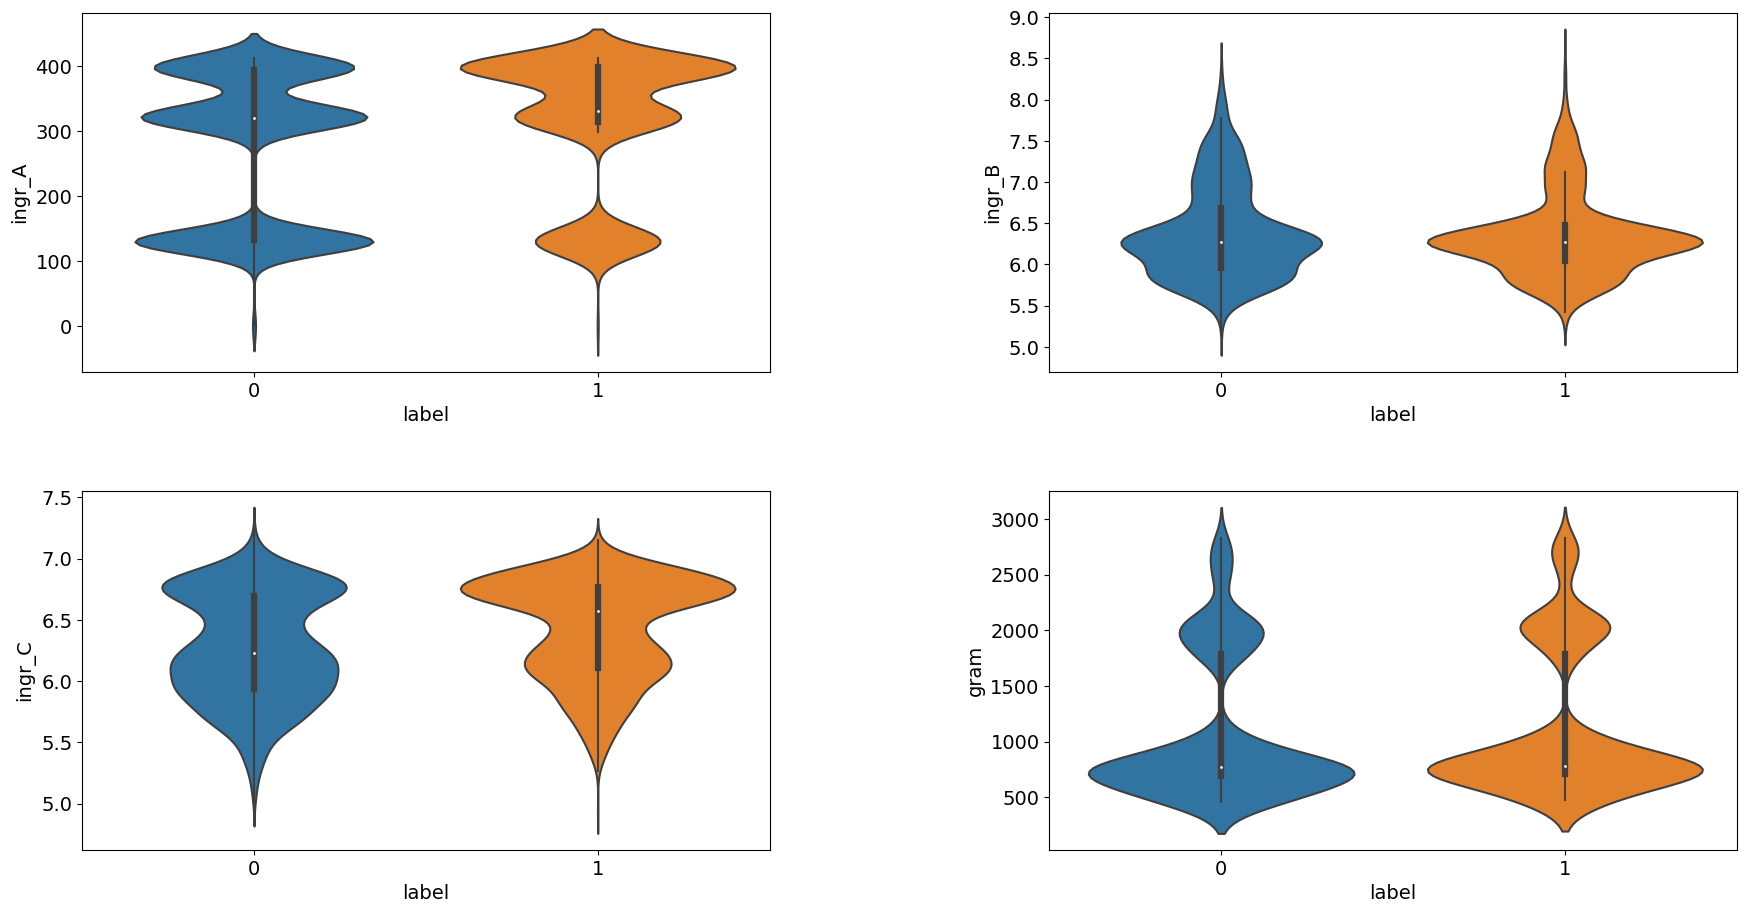

In [82]:
mpl.rc('font', size=14)
mpl.rc('axes', titlesize=15)
figure, axes = plt.subplots(nrows=2, ncols=2) # 2행 2열 Figure 생성
plt.tight_layout() # 그래프 사이에 여백 확보
figure.set_size_inches(20,10) # 전체 Figure 크기를 10 x 9인치로 설정

sns.violinplot(x='label', data=train, y='ingr_A', ax=axes[0,0])

ingr_B_outlier_delete_train = train.drop([1500,4750], axis=0, inplace=False)

sns.violinplot(x='label', data=balanced_df, y='ingr_B', ax=axes[0,1])
sns.violinplot(x='label', data=balanced_df, y='ingr_C', ax=axes[1,0])
sns.violinplot(x='label', data=balanced_df, y='gram', ax=axes[1,1])



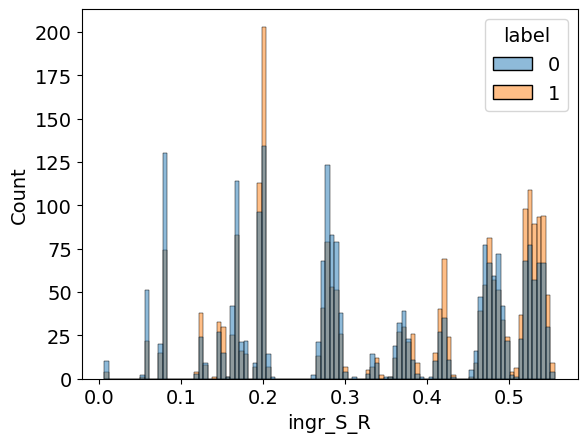

In [88]:
sns.histplot(data=balanced_df, x="ingr_S_R", hue='label', bins=100)
plt.show()

In [83]:
balanced_df['ingr_A_R'] = balanced_df['ingr_A'] / balanced_df['gram']
balanced_df['ingr_B_R'] = balanced_df['ingr_B'] / balanced_df['gram']
balanced_df['ingr_C_R'] = balanced_df['ingr_C'] / balanced_df['gram']
balanced_df['ingr_S'] = balanced_df['ingr_A'] + balanced_df['ingr_B']+ balanced_df['ingr_C']
balanced_df['ingr_S_R'] = balanced_df['ingr_S'] / balanced_df['gram']

In [ ]:
##제품별

In [93]:
balanced_df_gbmd = balanced_df[balanced_df['prod']=='GBMD']

In [94]:
balanced_df_gbmd

,Num,prod,insp,date,buydate,ingr_A,ingr_B,ingr_C,wtcd,gram,...,buydate_month,buydate_day,date_weekday,buydate_weekday,days_between,ingr_A_R,ingr_B_R,ingr_C_R,ingr_S,ingr_S_R
0,Sanchun,GBMD,C,2023-06-18,2023-09-18,399.4063,6.4035,6.9409,F3,970.32,...,09,18,Sunday,Monday,92,0.411623,0.006599,0.007153,412.7507,0.425376
3,Sanchun,GBMD,K,2023-05-05,2023-06-04,128.5978,6.8720,6.1705,F3,707.94,...,06,04,Friday,Sunday,30,0.181651,0.009707,0.008716,141.6403,0.200074
21,Opo,GBMD,Y,2023-04-17,2023-04-20,333.7603,5.6518,6.3664,F2,907.18,...,04,20,Monday,Thursday,3,0.367910,0.006230,0.007018,345.7785,0.381158
50,Sanchun,GBMD,C,2023-04-28,2023-09-06,321.8036,5.6769,5.8723,F2,886.08,...,09,06,Friday,Wednesday,131,0.363177,0.006407,0.006627,333.3528,0.376211
56,Changha,GBMD,L,2023-06-29,2023-07-12,398.3114,6.1343,6.4944,F2,998.48,...,07,12,Thursday,Wednesday,13,0.398918,0.006144,0.006504,410.9401,0.411566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2781,Susung,GBMD,C,2023-05-16,2023-09-15,131.5302,7.0101,5.2793,F3,799.09,...,09,15,Tuesday,Friday,122,0.164600,0.008773,0.006607,143.8196,0.179979
7501,Changha,GBMD,K,2023-06-06,2023-10-06,395.8951,6.1998,6.7814,F3,981.99,...,10,06,Tuesday,Friday,122,0.403156,0.006314,0.006906,408.8763,0.416375
1930,Changha,GBMD,K,2023-05-18,2023-08-03,128.3121,7.1316,5.5780,F3,716.08,...,08,03,Thursday,Thursday,77,0.179187,0.009959,0.007790,141.0217,0.196936
3309,Opo,GBMD,Y,2023-05-09,2023-05-21,131.5355,5.6228,5.7157,F3,703.83,...,05,21,Tuesday,Sunday,12,0.186885,0.007989,0.008121,142.8740,0.202995


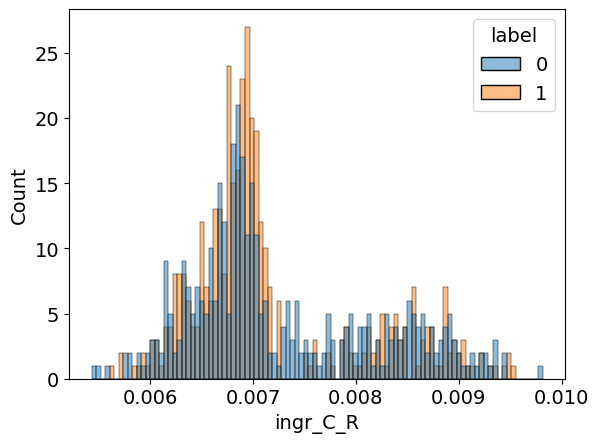

In [99]:
sns.histplot(data=balanced_df_gbmd, x="ingr_C_R", hue='label', bins=100)
plt.show()

### 이상치 탐지

In [ ]:
# 이상치 탐지 코드
def outlier_iqr(data, column):

    # lower, upper 글로벌 변수 선언하기
    global lower, upper

    # 4분위수 기준 지정하기
    q25, q75 = np.quantile(data[column], 0.25), np.quantile(data[column], 0.75)

    # IQR 계산하기
    iqr = q75 - q25

    # outlier cutoff 계산하기
    cut_off = iqr * 3.0

    # lower와 upper bound 값 구하기
    lower, upper = q25 - cut_off, q75 + cut_off

    print('IQR은',iqr, '이다.')
    print('lower bound 값은', lower, '이다.')
    print('upper bound 값은', upper, '이다.')

    # 1사 분위와 4사 분위에 속해있는 데이터 각각 저장하기
    upper_outlier = data[data[column] > upper]
    lower_outlier = data[data[column] < lower]

    return upper_outlier, lower_outlier

In [ ]:
ingrB_upper_outlier, ingrB_lower_outlier = outlier_iqr(train, 'ingr_B')

IQR은 0.6488749999999994 이다.
lower bound 값은 4.025125000000002 이다.
upper bound 값은 8.567249999999998 이다.


In [ ]:
ingrB_upper_outlier = train.iloc[[1500, 4750]]

In [ ]:
ingrB_upper_outlier

,Num,prod,insp,date,buydate,ingr_A,ingr_B,ingr_C,wtcd,gram,...,Num2,date_year,date_month,date_day,buydate_year,buydate_month,buydate_day,date_weekday,buydate_weekday,days_between
1500,Opo,JJBB,K,2023-04-20,2023-06-17,319.0863,64811.0,6.7270,NaN,1972.70,...,A,2023,04,20,2023,06,17,Thursday,Saturday,58
4750,Opo,GBMD,L,2023-04-14,2023-10-12,321.9846,74528.0,6.1506,NaN,897.94,...,A,2023,04,14,2023,10,12,Friday,Thursday,181


### days_between의 라벨에 따른 분포

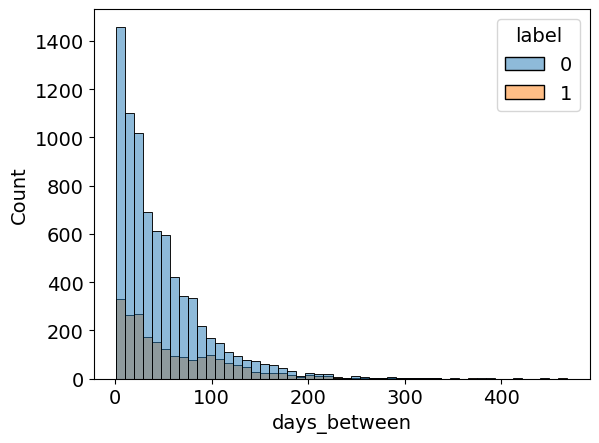

In [ ]:
sns.histplot(data=train, x="days_between", hue='label', bins=50)
plt.show()

<Axes: xlabel='label', ylabel='days_between'>

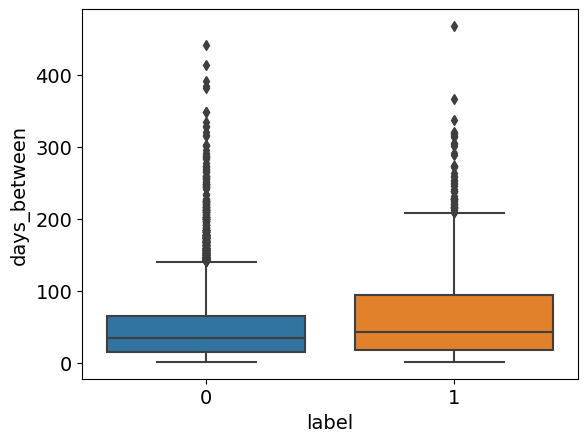

In [ ]:
sns.boxplot(x='label', data=train, y='days_between')

## Training 을 위한 전처리

In [261]:
from sklearn.model_selection import train_test_split
df_train = pd.read_csv(data_path + 'train.csv', encoding='utf-8')
df_test = pd.read_csv(data_path + 'test.csv', encoding='utf-8')
X_train = df_train.drop(columns=['label'])
y_train = df_train['label']
X_test = df_test.drop(columns=['label'])
y_test = df_test['label']

In [164]:
X_test

,index,Num,prod,insp,date,buydate,ingr_A,ingr_B,ingr_C,wtcd,gram
0,0,20230612창하037218A,KCMD,L,2023-06-12,2023-07-24,400.0039,6.4270,6.6832,F3,793.14
1,1,20230517수성043557C,KCMD,L,2023-05-17,2023-07-21,130.8366,6.9564,6.2847,F3,515.14
2,3,20230413산천098810A,JJBB,Y,2023-04-13,2023-05-19,327.4969,7.2336,5.9245,F2,2035.66
3,4,20230624산천036074A,KCMD,L,2023-06-24,2023-07-18,394.2496,6.3044,6.8083,F3,772.78
4,5,20230426수성067031C,GBMD,C,2023-04-26,2023-05-08,319.6806,5.8364,5.9225,F3,977.31
...,...,...,...,...,...,...,...,...,...,...,...
39995,49994,20230404창하079557B,KCMD,C,2023-04-04,2023-06-26,324.2386,7.3920,5.9031,F2,678.66
39996,49995,20230504창하044544B,KCMD,L,2023-05-04,2023-05-16,130.0161,6.3554,6.1290,F3,489.44
39997,49996,20230519오포044862A,GGMD,L,2023-05-19,2023-06-02,130.4973,7.1619,5.9173,F1,2551.65
39998,49998,20230527창하063270A,KCMD,C,2023-05-27,2023-05-29,131.5529,5.8700,6.2282,F3,524.21


In [251]:
df_train_bull = df_train[df_train['label']==0]
X_train = df_train_bull.drop(columns=['label'])
distribution = [0] * 78 + [1] * 22
y_train = np.random.choice(distribution, size=len(X_train), replace=True)

In [262]:
import random
from datetime import datetime
import calendar
from sklearn.preprocessing import LabelEncoder
# Get the unique values in the column
unique_values = X_train['wtcd'].unique()

# Calculate the percentages dynamically
probabilities = {value: (X_train['wtcd'] == value).sum() / len(X_train['wtcd']) for value in unique_values}
probabilities = {key: value / sum(probabilities.values()) for key, value in probabilities.items()}
def preprocessing(data):
  # Make New Columns

  data['Num2'] = data['Num'].str[-1]
  data['Num'] = data['Num'].str[8:-7]
  Num_mapping = {
    '산천': 'Sanchun',
    '창하': 'Changha',
    '수성': 'Susung',
    '오포': 'Opo',
  }
  data['Num'] = data['Num'].map(Num_mapping)




  data['date_year'] = data['date'].apply(lambda x: x.split('-')[0])
  data['date_month'] = data['date'].apply(lambda x: x.split('-')[1])
  data['date_day'] = data['date'].apply(lambda x: x.split('-')[2])

  data['buydate_year'] = data['buydate'].apply(lambda x: x.split('-')[0])
  data['buydate_month'] = data['buydate'].apply(lambda x: x.split('-')[1])
  data['buydate_day'] = data['buydate'].apply(lambda x: x.split('-')[2])


  data['date_weekday'] = data['date'].apply(
      lambda dateString:
      calendar.day_name[datetime.strptime(dateString, "%Y-%m-%d").weekday()])

  data['buydate_weekday'] = data['buydate'].apply(
      lambda dateString:
      calendar.day_name[datetime.strptime(dateString, "%Y-%m-%d").weekday()])

  data['days_between'] = (pd.to_datetime(data['buydate']) - pd.to_datetime(data['date'])).dt.days


  data['ingr_A_R'] = data['ingr_A'] / data['gram']
  data['ingr_B_R'] = data['ingr_B'] / data['gram']
  data['ingr_C_R'] = data['ingr_C'] / data['gram']
  data['ingr_S'] = data['ingr_A'] + data['ingr_B']+ data['ingr_C']
  data['ingr_S_R'] = data['ingr_S'] / data['gram']


  # `wtcd` Null 값 처리
  data['wtcd'] = data.apply(lambda row: random.choices(list(probabilities.keys()), weights=list(probabilities.values()))[0] if pd.isnull(row['wtcd']) else row['wtcd'], axis=1)


  data['ingr_B'] = data['ingr_B'].apply(lambda x: x / 10000 if x >= 10 else x)


  # Drop Columns
  data = data.drop(columns = ['date', 'buydate', 'date_year', 'index', 'date_day', 'buydate_day', 'buydate_year', 'buydate_month', 'date_weekday', 'buydate_weekday', 'date_month'])





  # List of columns to one-hot encode
  columns_to_encode = ['Num', 'Num2', 'prod', 'insp', 'wtcd']  # Add more columns if needed

  # Apply one-hot encoding to selected columns
  data = pd.get_dummies(data, columns=columns_to_encode)


  # columns_to_encode = ['Num', 'Num2', 'prod', 'insp', 'wtcd']

  # # Apply label encoding to selected columns
  # label_encoder = LabelEncoder()

  # for column in columns_to_encode:
  #     data[column] = label_encoder.fit_transform(data[column])

  return data



In [ ]:
6.4035

In [263]:
X_train = preprocessing(X_train)
X_train

,ingr_A,ingr_B,ingr_C,gram,days_between,ingr_A_R,ingr_B_R,ingr_C_R,ingr_S,ingr_S_R,...,prod_JJBB,prod_KCMD,insp_C,insp_K,insp_L,insp_P,insp_Y,wtcd_F1,wtcd_F2,wtcd_F3
0,399.4063,6.4035,6.9409,970.32,92,0.411623,0.006599,0.007153,412.7507,0.425376,...,0,0,1,0,0,0,0,0,0,1
1,130.0951,5.8245,6.2857,2490.08,51,0.052245,0.002339,0.002524,142.2053,0.057109,...,0,0,0,0,1,0,0,1,0,0
2,131.5192,5.8040,6.0607,487.37,58,0.269855,0.011909,0.012436,143.3839,0.294199,...,0,1,1,0,0,0,0,0,0,1
3,128.5978,6.8720,6.1705,707.94,30,0.181651,0.009707,0.008716,141.6403,0.200074,...,0,0,0,1,0,0,0,0,0,1
4,320.6915,5.7474,6.3695,1978.66,5,0.162075,0.002905,0.003219,332.8084,0.168199,...,1,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,405.6626,6.2900,6.8467,777.82,18,0.521538,0.008087,0.008802,418.7993,0.538427,...,0,1,1,0,0,0,0,0,0,1
9996,129.1664,6.0345,6.5257,2548.73,10,0.050679,0.002368,0.002560,141.7266,0.055607,...,0,0,0,1,0,0,0,0,0,1
9997,403.9895,6.2698,6.7227,2769.71,88,0.145860,0.002264,0.002427,416.9820,0.150551,...,0,0,0,0,1,0,0,1,0,0
9998,309.4751,5.7987,6.5499,2005.46,11,0.154316,0.002891,0.003266,321.8237,0.160474,...,1,0,0,1,0,0,0,0,0,1


In [264]:
X_test = preprocessing(X_test)
X_test

,ingr_A,ingr_B,ingr_C,gram,days_between,ingr_A_R,ingr_B_R,ingr_C_R,ingr_S,ingr_S_R,...,prod_JJBB,prod_KCMD,insp_C,insp_K,insp_L,insp_P,insp_Y,wtcd_F1,wtcd_F2,wtcd_F3
0,400.0039,6.4270,6.6832,793.14,42,0.504330,0.008103,0.008426,413.1141,0.520859,...,0,1,0,0,1,0,0,0,0,1
1,130.8366,6.9564,6.2847,515.14,65,0.253983,0.013504,0.012200,144.0777,0.279686,...,0,1,0,0,1,0,0,0,0,1
2,327.4969,7.2336,5.9245,2035.66,36,0.160880,0.003553,0.002910,340.6550,0.167344,...,1,0,0,0,0,0,1,0,1,0
3,394.2496,6.3044,6.8083,772.78,24,0.510171,0.008158,0.008810,407.3623,0.527139,...,0,1,0,0,1,0,0,0,0,1
4,319.6806,5.8364,5.9225,977.31,12,0.327103,0.005972,0.006060,331.4395,0.339134,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,324.2386,7.3920,5.9031,678.66,83,0.477763,0.010892,0.008698,337.5337,0.497353,...,0,1,1,0,0,0,0,0,1,0
39996,130.0161,6.3554,6.1290,489.44,12,0.265643,0.012985,0.012522,142.5005,0.291150,...,0,1,0,0,1,0,0,0,0,1
39997,130.4973,7.1619,5.9173,2551.65,14,0.051142,0.002807,0.002319,143.5765,0.056268,...,0,0,0,0,1,0,0,1,0,0
39998,131.5529,5.8700,6.2282,524.21,2,0.250955,0.011198,0.011881,143.6511,0.274033,...,0,1,1,0,0,0,0,0,0,1


In [14]:
X_test.columns

Index(['ingr_A', 'ingr_B', 'ingr_C', 'gram', 'Num_Changha', 'Num_Opo',
       'Num_Sanchun', 'Num_Susung', 'Num2_A', 'Num2_B', 'Num2_C', 'prod_GBMD',
       'prod_GGMD', 'prod_JJBB', 'prod_KCMD', 'insp_C', 'insp_K', 'insp_L',
       'insp_P', 'insp_Y', 'wtcd_F1', 'wtcd_F2', 'wtcd_F3'],
      dtype='object')

In [271]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


columns_to_normalize = ['ingr_A', 'ingr_B', 'ingr_C', 'gram', 'days_between']


scaler = MinMaxScaler()


X_train[columns_to_normalize] = scaler.fit_transform(X_train[columns_to_normalize])

X_test[columns_to_normalize] = scaler.transform(X_test[columns_to_normalize])


In [27]:
X_train_4 = X_train[['ingr_A', 'ingr_B', 'ingr_C', 'gram', 'days_between']]
X_test_4 = X_test[['ingr_A', 'ingr_B', 'ingr_C', 'gram', 'days_between']]

In [29]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
X_train_pca =pca.fit_transform(X_train)
X_test_pca =pca.transform(X_test)

In [41]:
eda = pd.DataFrame(X_train_pca, columns=['Column1', 'Column2'])
eda['label'] = y_train.values

<Axes: xlabel='Column1', ylabel='Column2'>

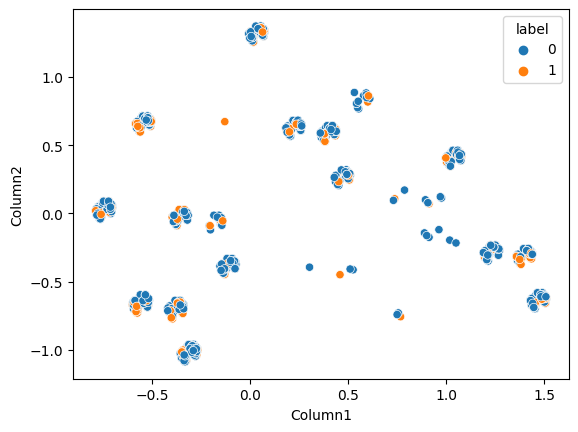

In [42]:
sns.scatterplot(x='Column1', y='Column2', data=eda, hue='label')

## Baseline Models

In [272]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
model = DecisionTreeClassifier(random_state=123, max_depth=8)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8, random_state=123)

In [273]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
accuracy_score(y_test, y_pred)

0.76275

In [274]:
y_test

0        0
1        0
2        0
3        0
4        0
        ..
39995    1
39996    0
39997    0
39998    0
39999    1
Name: label, Length: 40000, dtype: int64

In [275]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score}")

AUC Score: 0.6110014916036893


In [280]:
from sklearn.ensemble import RandomForestClassifier

rf_clf_500 = RandomForestClassifier(n_estimators=500, random_state=123, max_depth=12, min_samples_leaf=8, min_samples_split= 8)
rf_clf_500.fit(X_train, y_train)

SyntaxError: ignored

In [277]:
from sklearn.metrics import accuracy_score

y_pred = rf_clf_500.predict(X_test)
y_pred_proba = rf_clf_500.predict_proba(X_test)[:, 1]
accuracy_score(y_test, y_pred)
#accuracy_score(y_test, y_pred)

0.771875

In [278]:
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score}")

AUC Score: 0.6265905658009377


In [279]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score

# Assuming you have X_train and y_train defined
# Replace this with your actual data

params = {'n_estimators': [10, 100],
          'max_depth': [6, 8, 10, 12],
          'min_samples_leaf': [8, 12, 18],
          'min_samples_split': [8, 16, 20]}

# RandomForestClassifier object
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)

# Define the scoring metric as 'roc_auc'
scorer = make_scorer(roc_auc_score)

# GridSearchCV with AUC as the scoring metric
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=3, n_jobs=-1, scoring=scorer)
grid_cv.fit(X_train, y_train)

# Print the results
print('최적 하이퍼 파라미터:', grid_cv.best_params_)
print('최고 AUC 스코어: {:.4f}'.format(grid_cv.best_score_))


최적 하이퍼 파라미터: {'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 10}
최고 AUC 스코어: 0.5120


In [212]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_test)
accuracy_score(y_test, y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.779975

In [213]:
auc_score = roc_auc_score(y_test, y_pred)
print(f"AUC Score: {auc_score}")

AUC Score: 0.5026709691351562


In [214]:
from xgboost import  XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [215]:
y_pred = xgb.predict(X_test)
accuracy_score(y_test, y_pred)

0.759075

In [216]:
auc_score = roc_auc_score(y_test, y_pred)
print(f"AUC Score: {auc_score}")

AUC Score: 0.5206647496111044


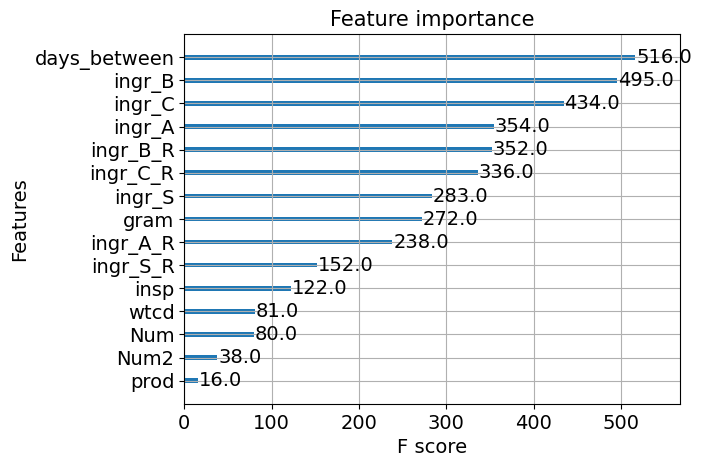

In [217]:
from xgboost import plot_importance
ax = plot_importance(xgb)

<Axes: xlabel='gram', ylabel='ingr_S'>

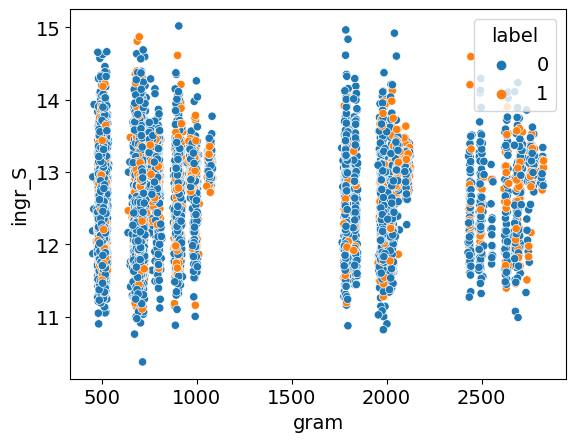

In [ ]:
eda = pd.concat([X_train, y_train], axis=1)
eda['ingr_S'] = eda['ingr_B'] + eda['ingr_C']
sns.scatterplot(x='gram', y='ingr_S', hue='label', data=eda)